In [2]:
import torch
import matplotlib.pyplot as plt
import BVP_function as bvp
import numpy as np
import deepxde as dde
import os

import seaborn as sns
sns.set_style("whitegrid") # better looking plots

print("Using GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

from importlib import reload
reload(bvp)

Using backend: pytorch
Other available backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
 


Using GPU: True


<module 'BVP_function' from 'C:\\Users\\u0150568\\PhD\\code\\github\\pinn-cm\\inverse\\BVP_function.py'>

In [18]:
reload(bvp)

lmbd = torch.tensor(1.0)
mu = torch.tensor(0.5)

lmbd_trainable = dde.Variable(lmbd - 0.1)
mu_trainable = dde.Variable(mu + 0.1)
Q = 4.0

domain = np.array([[0.0, 1.0], [0.0, 1.0]])
geom = dde.geometry.Rectangle([0, 0], [1, 1])

phy_params = {'lmbd': lmbd, 'mu': mu, 'Q': Q}
phy_params_trainable = {'lmbd': lmbd_trainable, 'mu': mu_trainable, 'Q': Q}

#net parameters
net_type = ['Unet','USnet'][1]
n_layers = 4
size_layers = 50
activation = ['tanh','ReLU','Sigmoid'][0]

#loss parameters
loss_type = ['pde','energy'][0] #the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following
num_domain = 50**2
train_distribution = ['uniform','pseudo','LHS','Halton','Hammersley','Sobol'][4]

#boundary conditions
bc_type = ['soft','hard'][1]
num_boundary = 50

#optimizer
optimizers = ["adam","L-BFGS"]
learning_rates = [1e-3,None]
iterations = [3000,None]

config = {'net_type':net_type,'n_layers':n_layers,'size_layers':size_layers,'activation':activation,
        'loss_type':loss_type,'num_domain':num_domain,'train_distribution':train_distribution,
        'bc_type':bc_type,'num_boundary':num_boundary,
        'optimizers':optimizers,'learning_rates':learning_rates,'iterations':iterations}  

net_exact = bvp.set_exact_solution(net_type, phy_params,lib='np')

# net = dde.nn.PFNN([2, [20]*5, [20]*5, [20]*5,[20]*5, 5], "tanh", "Glorot normal")
net = dde.nn.FNN([2, 50 ,50 ,50 ,50 , 5], "sin", "Glorot normal")
net_wrong_elasticity,total_loss,bc,pde_net,energy_net,mat_net = bvp.net_setup(net,net_type,bc_type,loss_type,geom,phy_params,phy_params_trainable)

In [15]:
def generate_measures(domain, num_points, func, noise=0.0, seed=None):
    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(num_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(num_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    X_obs = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
    Yexact = func(X_obs)
    Y_obs = Yexact# + noise * np.random.randn(*Yexact.shape)
    return X_obs, Y_obs

# generate training data
S_exact = lambda X: bvp.S_exact(X,phy_params)
U_exact = lambda X: bvp.U_exact(X,phy_params)

X_obs, U_obs = generate_measures(domain, 1000, U_exact, noise=0.0)
X_obs, S_obs = generate_measures(domain, 1000, S_exact, noise=0.0)


observe_Ux = dde.PointSetBC(X_obs, U_obs[:, 0:1], component=0)
observe_Uy = dde.PointSetBC(X_obs, U_obs[:, 1:2], component=1)

observe_Sx = dde.PointSetBC(X_obs, S_obs[0].reshape(-1, 1), component=2)
observe_Sy = dde.PointSetBC(X_obs, S_obs[1].reshape(-1, 1), component=3)
observe_Sxy = dde.PointSetBC(X_obs, S_obs[2].reshape(-1, 1), component=4)



# material_behavior = dde.icbc.OperatorBC()
bc += [observe_Ux, observe_Uy]
# bc += [observe_Sx, observe_Sy, observe_Sxy]

num_domain = 300

data = dde.data.PDE(
    geom,
    total_loss,
    bc,
    num_domain=num_domain,
    num_test= num_domain,
    solution=net_exact,
    anchors=X_obs,
)

model = dde.Model(data, net_wrong_elasticity)

# sanity check that BCs are enforced
U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: bvp.S_nn(bvp.E_nn(x,ouput),phy_params_trainable) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

# fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
# fig = bvp.plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")

In [20]:
trainable_variables = [lmbd_trainable, mu_trainable]
variable = dde.callbacks.VariableValue(trainable_variables, period=50, filename="elasticity_param.dat")
fname = "saved_model"
loss_weights = [1,1,1,1,1,1,1,1]

# model.compile("adam", lr=1e-3, external_trainable_variables=trainable_variables, metrics=["l2 relative error"])#,loss_weights=loss_weights)
# model.restore(os.path.join(fname,"USnet_lmbd-1.0_mu-0.5-12000.pt"),device=device)
# losshistory, train_state = model.train(iterations=50,display_every=50, callbacks=[variable])

# model.compile("adam", lr=0.001, external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
# losshistory, train_state = model.train(iterations=3000,display_every=1000, callbacks=[variable])

# model.compile("adam", lr=0.0001, external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
# losshistory, train_state = model.train(iterations=5000,display_every=1000, callbacks=[variable])

# # train lbfgs
print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")
model.compile("L-BFGS", external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
dde.optimizers.config.set_LBFGS_options(maxiter=5000,maxfun=100 )
losshistory, train_state = model.train(callbacks=[variable],display_every=100,batch_size=100)
print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")

lambda:0.8999999761581421 ; mu: 0.6000000238418579
Compiling model...
'compile' took 0.000249 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
6100      [5.34e-04, 1.64e-04, 1.52e-04, 6.05e-06, 2.87e-05]    [3.76e-04, 1.13e-04, 1.12e-04, 6.05e-06, 2.87e-05]    [5.07e-01]    
7100      [3.84e-04, 1.15e-04, 1.07e-04, 4.43e-06, 1.95e-05]    [2.84e-04, 9.05e-05, 7.41e-05, 4.43e-06, 1.95e-05]    [5.09e-01]    
8100      [2.74e-04, 8.10e-05, 1.04e-04, 5.17e-06, 1.97e-05]    [1.92e-04, 5.77e-05, 7.42e-05, 5.17e-06, 1.97e-05]    [5.10e-01]    
9100      [1.64e-04, 6.62e-05, 9.97e-05, 3.32e-06, 2.28e-05]    [1.16e-04, 5.09e-05, 7.89e-05, 3.32e-06, 2.28e-05]    [5.09e-01]    
10100     [1.23e-04, 5.99e-05, 8.90e-05, 2.78e-06, 1.88e-05]    [8.13e-05, 5.05e-05, 6.10e-05, 2.78e-06, 1.88e-05]    [5.09e-01]    


KeyboardInterrupt: 

In [21]:
print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")

lambda:0.8999999761581421 ; mu: 0.6000000238418579


In [163]:
fname = "saved_model"
save_run = True
if save_run:
    model.compile("adam", lr=0.01, external_trainable_variables=trainable_variables, metrics=["l2 relative error"],loss_weights=loss_weights)
    model.train(iterations=0,model_save_path=os.path.join(fname, f"{net_type}_lmbd-{lmbd}_mu-{mu}"))

Compiling model...
'compile' took 0.000404 s

Training model...

12000     [3.31e-05, 3.30e-05, 1.76e-05, 3.25e-07, 2.88e-07]    [2.27e-05, 2.66e-05, 1.07e-05, 3.25e-07, 2.88e-07]    [4.91e-03]    

Best model at step 12000:
  train loss: 8.43e-05
  test loss: 6.05e-05
  test metric: [4.91e-03]

Epoch 12000: saving model to saved_model\USnet_lmbd-1.0_mu-0.5-12000.pt ...

'train' took 0.072018 s



In [134]:
f"{net_type}_lmbd-{lmbd}_mu-{mu}"

'USnet_lmbd-1.0_mu-0.5'

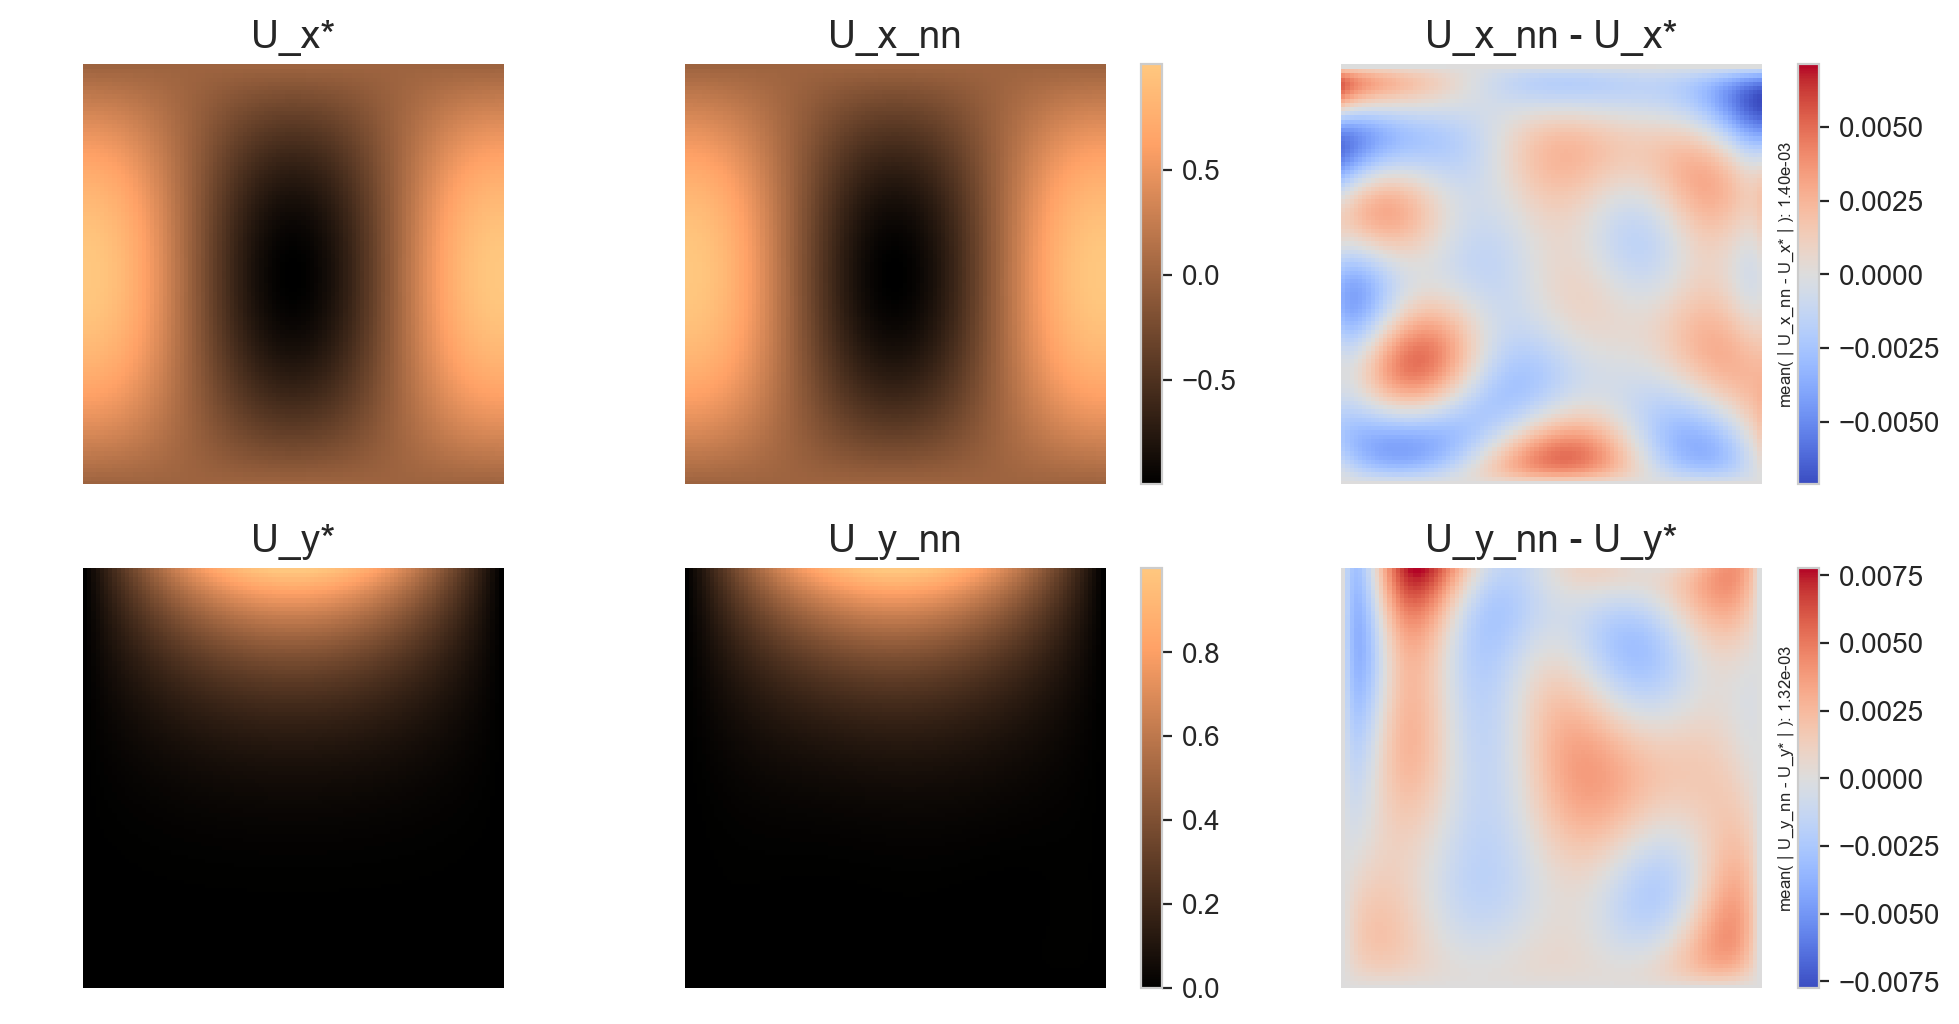

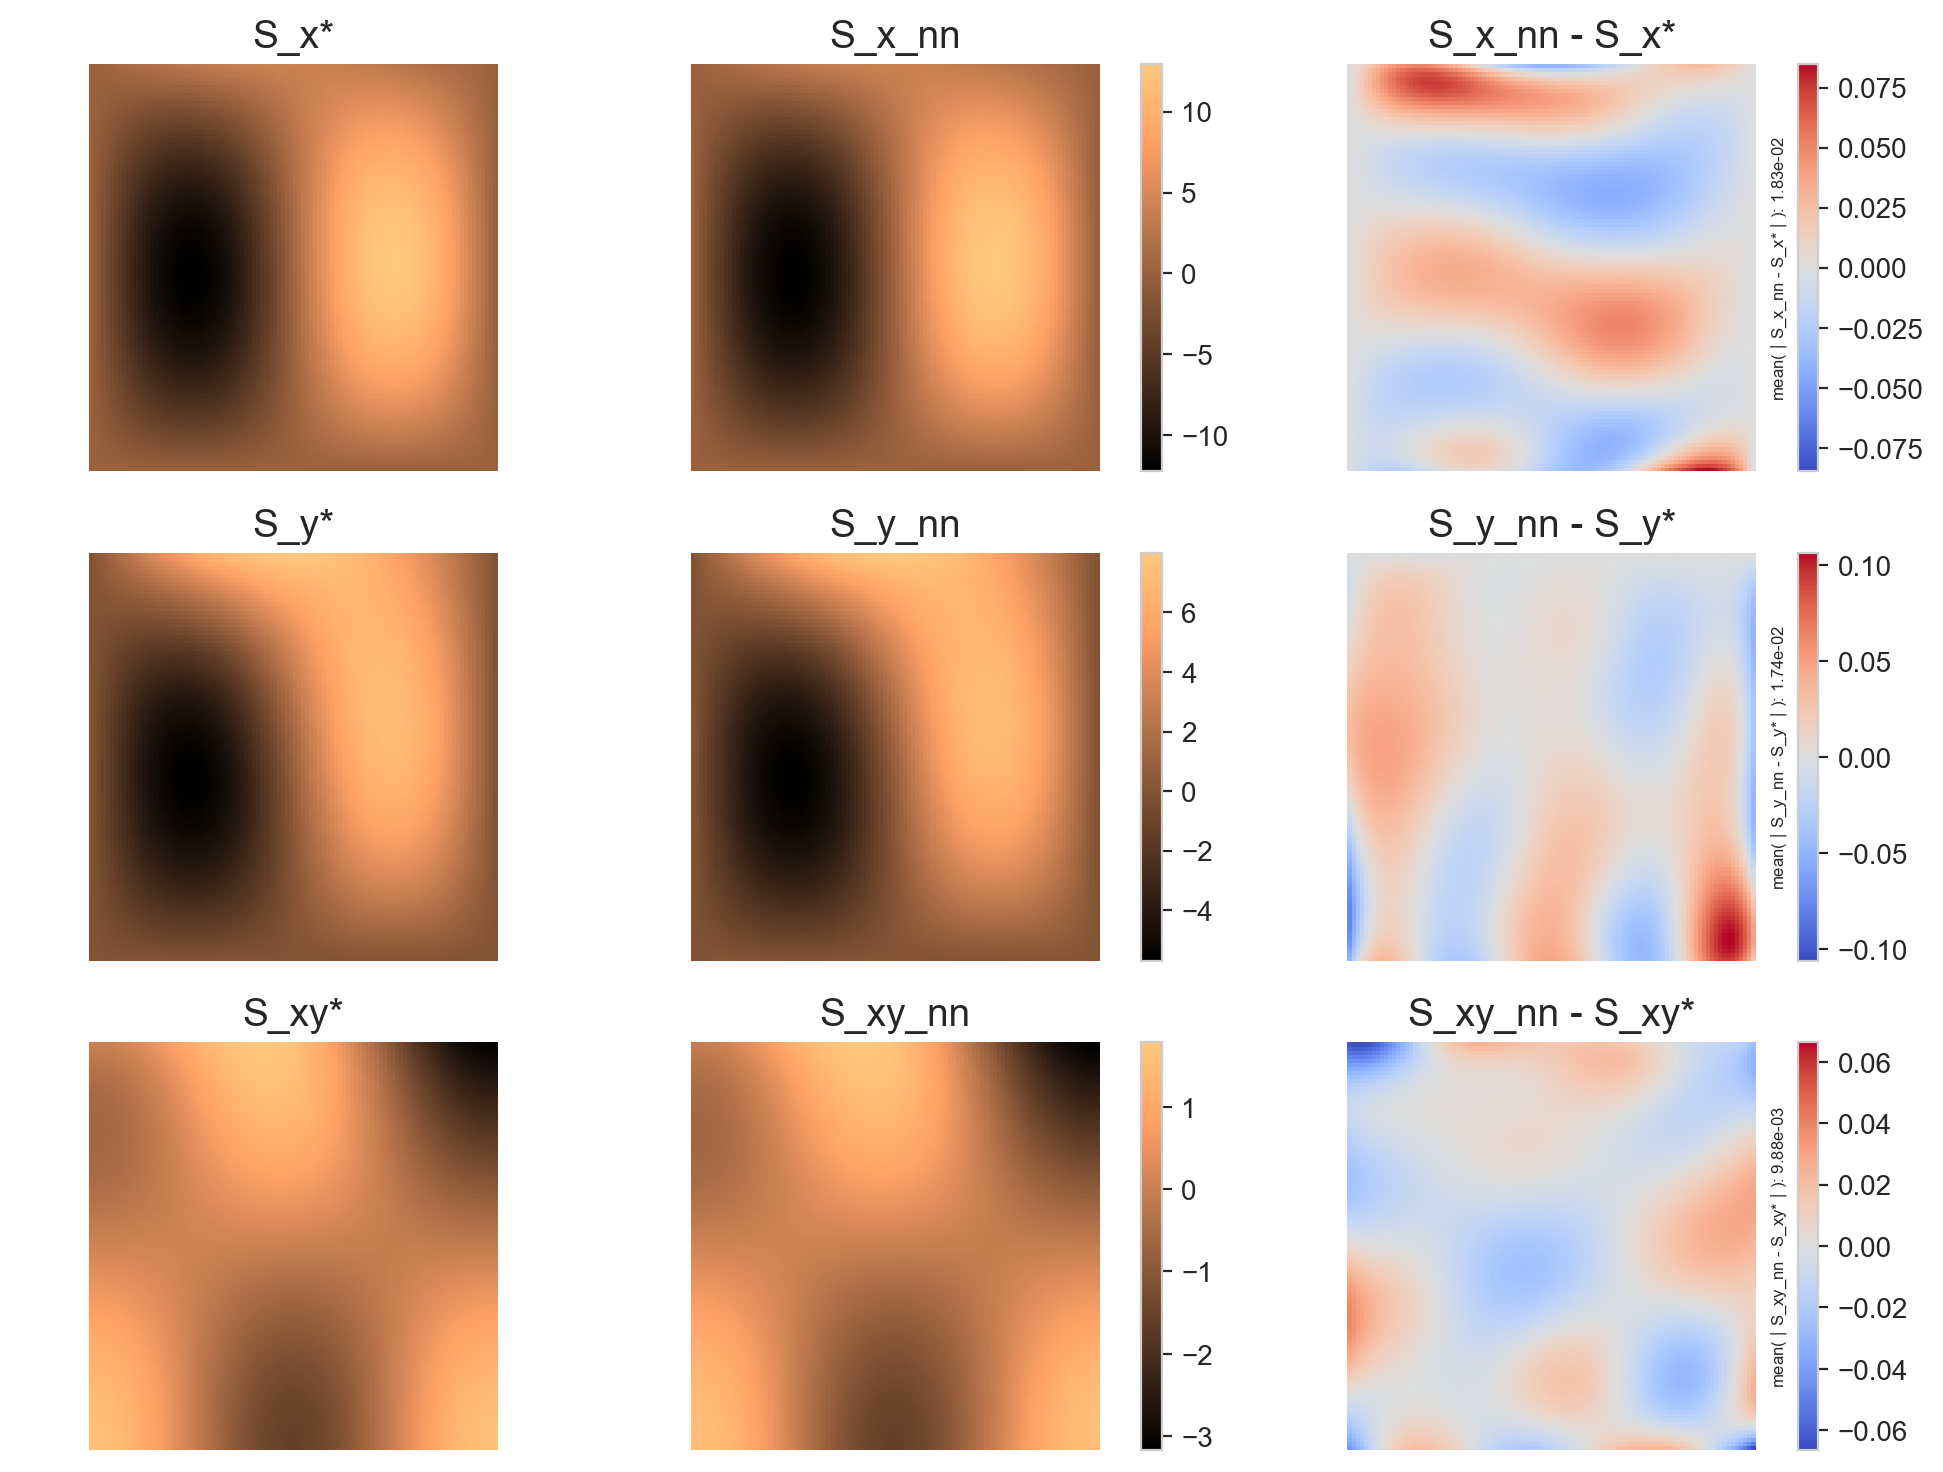

In [207]:
S_exact = lambda X: bvp.S_exact(X,phy_params)
U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: bvp.S_nn(bvp.E_nn(x,ouput),phy_params_trainable) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
fig = bvp.plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")

In [124]:
print(phy_params_trainable)
print(phy_params)

{'lmbd': tensor(0.0581, requires_grad=True), 'mu': tensor(0.9685, requires_grad=True), 'Q': 4.0}
{'lmbd': tensor(1.), 'mu': tensor(0.5000), 'Q': 4.0}
